# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Определим рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head(20)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

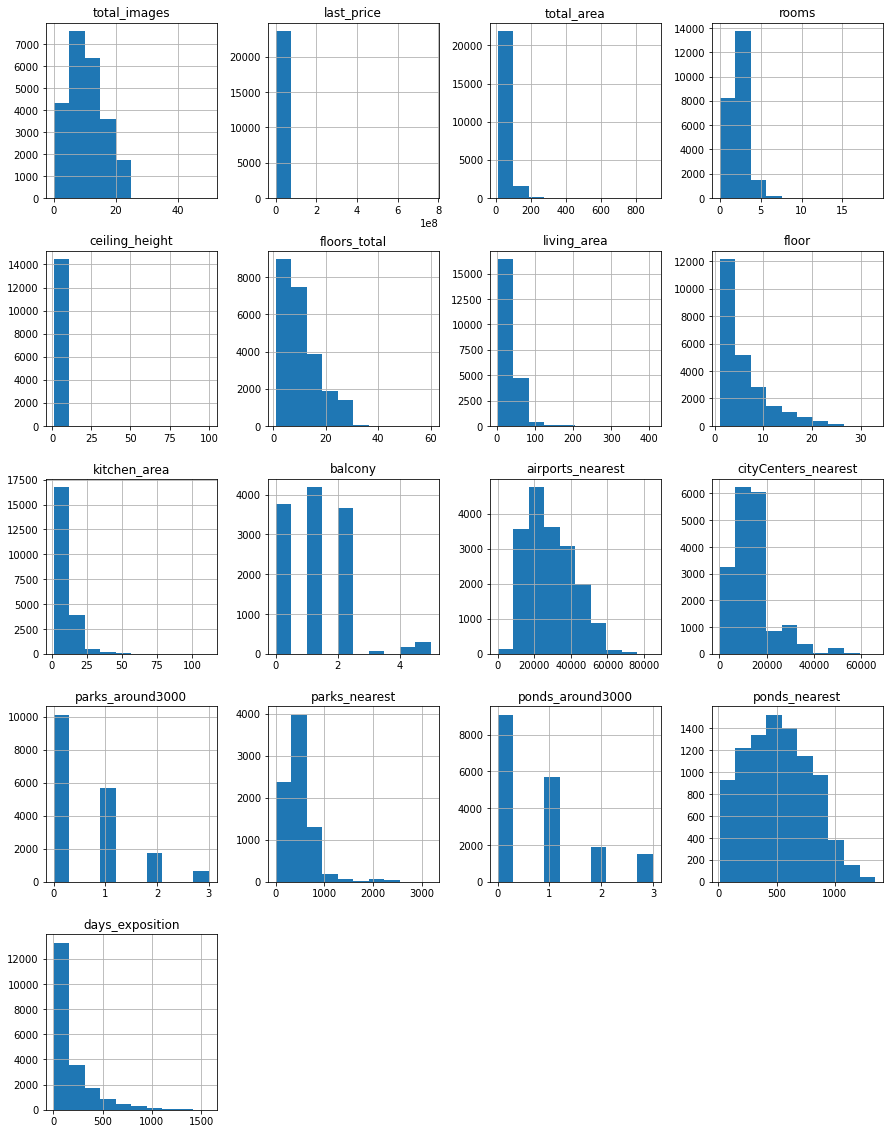

In [2]:
data.hist(figsize=(15, 20));

### Предобработка данных

In [3]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В столбце days_exposition информация может отсутствовать или присутствовать аномально большие значения, например, по причине того, что неизвестно когда было закрыто объявление о продаже, не выгрузились данные, объявление было ошибочно снято. Но установить в пропусках или аномалиях "среднее"/"медианальное" значение не получится. Можно было бы посмотреть, как продавались квартиры с теми же параметрами, но возможно в какой-то из квартир был зороший ремонт или наоборот значительные дефекты в доме/подъезде/самой квартире, что сильно повлияло на срок продажи, а этих данных в таблице нет. Поэтому оставляем этот столбец с данными, которые у нас есть.

In [4]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')
data['is_apartment'] = data['is_apartment'].fillna(False)

Пропущенные значения в locality_name не будем трогать, причина не понятна.

Переведем столбец с датой в формат даты без времени, т.к. время не указано.

In [5]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

Пропуски в значениях airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest трогать не будем. Они зависят от географического расположения объекта.

Рассмотрим параметр ceiling_height, видим что есть необоснованно большие значения но пока оставим их как есть.
Медиана от среднего отличается не сильно из-за этих выбросов во всей выборке.

<AxesSubplot:ylabel='Frequency'>

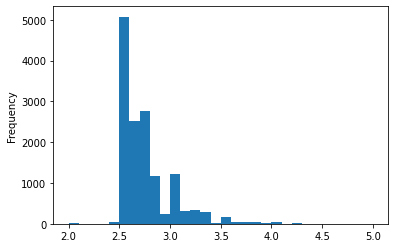

In [6]:
data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))

In [7]:
data['ceiling_height'].value_counts()
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [8]:
data[data['ceiling_height'] > 4].sort_values('ceiling_height').tail(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
18545,6,3750000.0,43.0,2019-03-18,2,25.0,5.0,29.0,3,False,...,NaN,0,Санкт-Петербург,27054.0,8033.0,1.0,540.0,0.0,NaN,12.0
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
6246,6,3300000.0,44.4,2019-03-25,2,25.0,5.0,31.3,5,False,...,5.7,0,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
14382,9,1700000.0,35.0,2015-12-04,1,25.0,5.0,20.0,2,False,...,8.0,1,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,206.0
11285,0,1950000.0,37.0,2019-03-20,1,25.0,5.0,17.0,4,False,...,9.0,2,Луга,NaN,NaN,NaN,NaN,NaN,NaN,18.0
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,False,...,7.0,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
9379,5,3950000.0,42.0,2017-03-26,3,25.0,5.0,30.0,2,False,...,5.2,0,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN
5669,4,4400000.0,50.0,2017-08-08,2,26.0,9.0,21.3,3,False,...,7.0,2,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,False,...,12.0,5,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,False,...,9.0,2,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0


Изменим цену на тип int для удобства просмотра

In [9]:
data['last_price'] = data['last_price'].astype('int')
data['last_price']

0        13000000
1         3350000
2         5196000
3        64900000
4        10000000
           ...   
23694     9700000
23695     3100000
23696     2500000
23697    11475000
23698     1350000
Name: last_price, Length: 23699, dtype: int64

Посмотрим данные с пропущенными значениями в floors_total- никакой связи между ними нет, оставим как есть.

In [10]:
data[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000,65.2,2018-10-02,2,NaN,NaN,30.80,4,False,...,12.00,0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033,28.1,2016-11-23,1,NaN,NaN,20.75,1,False,...,NaN,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348,70.8,2015-08-01,2,NaN,NaN,38.40,12,False,...,10.63,0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191,93.6,2017-04-06,3,NaN,NaN,47.10,8,False,...,16.80,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000,39.0,2017-04-22,1,NaN,NaN,NaN,9,False,...,NaN,0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000,63.5,2017-05-24,2,2.8,NaN,NaN,3,False,...,NaN,0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160,64.5,2017-04-02,2,NaN,NaN,31.70,20,False,...,14.40,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263,110.4,2016-11-20,3,NaN,NaN,45.38,6,False,...,23.42,0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872,123.3,2017-04-25,3,NaN,NaN,50.40,18,False,...,23.60,0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


В living_area и kitchen_area слишком много знаков после запятой и есть пропущенные значения,оставим как есть.

In [11]:
data['living_area'].value_counts()

18.00    882
17.00    675
30.00    598
16.00    486
20.00    481
        ... 
96.40      1
50.26      1
43.81      1
54.43      1
16.74      1
Name: living_area, Length: 1782, dtype: int64

In [12]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [13]:
data['kitchen_area'].value_counts()

6.00     1300
10.00    1262
8.00     1110
9.00     1101
7.00     1062
         ... 
7.12        1
13.73       1
14.74       1
53.10       1
16.74       1
Name: kitchen_area, Length: 971, dtype: int64

In [14]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [15]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Причиной возникновения пропусков могут быть ошибки выгрузки данных или пропуск заполнения полей людьми. А также отсутствие параметров для заполнения. Например балконов в квартире.

Изучим уникальные  значения в столбце locality_name и избавимся от неявных повторов.

In [16]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [17]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.strip()
data['locality_name'] = data['locality_name'].str.replace('городской поселок ', '') 
data['locality_name'] = data['locality_name'].str.replace('городской посёлок ', '') 
data['locality_name'] = data['locality_name'].str.replace('деревня ', '') 
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок ', '') 
data['locality_name'] = data['locality_name'].str.replace('поселок ', '') 
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа ', '') 
data['locality_name'] = data['locality_name'].str.replace('поселок станции ', '') 
data['locality_name'] = data['locality_name'].str.replace('посёлок ', '') 
data['locality_name'] = data['locality_name'].str.replace('посёлок городского типа ', '') 
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество ', '') 
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ', '') 
data['locality_name'] = data['locality_name'].str.replace('село ', '') 
data['locality_name'] = data['locality_name'].str.replace('городского типа ', '') 
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной станции ', '') 
data['locality_name'] = data['locality_name'].str.replace('станции ', '') 
data['locality_name'] = data['locality_name'].str.replace('коттеджный ', '')
 

In [18]:
data['locality_name'].sort_values().unique() #проверим данные после обработки

array(['агалатово', 'александровская', 'алексеевка', 'аннино', 'аро',
       'барышево', 'батово', 'бегуницы', 'белогорка', 'белоостров',
       'бокситогорск', 'большая вруда', 'большая ижора',
       'большая пустомержа', 'большие колпаны', 'большое рейзино',
       'большой сабск', 'бор', 'борисова грива', 'бугры', 'будогощь',
       'ваганово', 'важины', 'вартемяги', 'вахнова кара', 'вещево',
       'виллози', 'вознесенье', 'возрождение', 'войсковицы', 'войскорово',
       'володарское', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'вырица', 'выскатка', 'высокоключевой', 'высоцк', 'гаврилово',
       'гарболово', 'гатчина', 'гладкое', 'глажево', 'глебычево',
       'глинка', 'гончарово', 'горбунки', 'гостилицы', 'громово',
       'дзержинского', 'дружная горка', 'дружноселье', 'дубровка',
       'елизаветино', 'ефимовский', 'жилгородок', 'жилпосёлок', 'житково',
       'заводской', 'заклинье', 'заневка', 'запорожское', 'зеленогорск',
       'зимитицы', 'ивангород', 'извара'

In [19]:
data.duplicated().sum()

0

In [20]:
data = data.drop_duplicates() #избавимся от явных дубликатов
data.duplicated().sum()

0

Обработаем аномальные значения в столбцах.


In [21]:
# функция, получающая на вход название стоолбца, и возвращающая границы "усов"
def whiskers(column):
    stat = data[column].describe()
    
    # межквартирльный размах
    iqr = stat[6] - stat[4]
    
    # левый и правый "ус"    
    left_whisker = round(stat[4] - 1.5 * iqr, 2)
    right_whisker = round(stat[6] + 1.5 * iqr, 2)

    # левый "ус" не должен быть меньше минимального значения
    if left_whisker < stat[3]:
        left_whisker = stat[3] 
        
    # правый "ус" не должен быть больше максимального значения
    if right_whisker > stat[7]:
        right_whisker = stat[7]
        
    return [left_whisker, right_whisker]

Добавим столбец с признаком, описывающим аномально большую общую площадь недвижимости, количество комнат, площадь кухни и высоту потолков.

In [22]:
data['too_large_area'] = data['total_area'] > whiskers('total_area')[1] #берем границу правого уса
data['too_large_living_area'] = data['living_area'] > whiskers('living_area')[1]
data['too_many_rooms'] = data['rooms'] > whiskers('rooms')[1]
data['too_large_kitchen_area'] = data['kitchen_area'] > whiskers('kitchen_area')[1]
data['unusual_ceiling'] = (data['ceiling_height'] > whiskers('ceiling_height')[1]) | (data['ceiling_height'] < whiskers('ceiling_height')[0])

Уберем редкие и выбивающиеся значения.

In [32]:
data = data[(data['too_large_area'] == False) & 
     (data['too_many_rooms'] == False) &
     (data['too_large_living_area'] == False) &
     (data['unusual_ceiling'] == False) &     
     (data['too_large_kitchen_area'] == False)].reset_index(drop=True)

Данные очищены от аномалий.

### Посчтаем и добавим в таблицу новые столбцы

In [25]:
data['m_price'] = data['last_price'] / data['total_area']  #добавляем столбец цена за квадратный метр
data['m_price'].astype('int') #Приведем к типу int для удобства
data['day_of_week'] = data['first_day_exposition'].dt.weekday #добавляем столбец день недели публикации объявления
data['month'] = data['first_day_exposition'].dt.month #добавляем столбец месяц публикации объявления
data['year'] = data['first_day_exposition'].dt.year #добавляем столбец год публикации объявления
data['day'] = data['first_day_exposition'].dt.day #добавляем столбец день публикации объявления

In [26]:
def type_floor(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'

Категоризуем этажи.

In [27]:
data['type_floor'] = data.apply(type_floor, axis = 1)

Добавим столбец расстояние до центра города в километрах и округлим его до целых.

In [28]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(999999) #Заполним пропуски большим значением
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')

### Проведем исследовательский анализ данных

Изучим общую площадь

<AxesSubplot:ylabel='Frequency'>

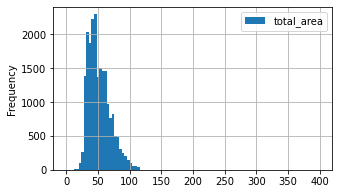

In [29]:
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,400))

Изучим жилую площадь

<AxesSubplot:ylabel='Frequency'>

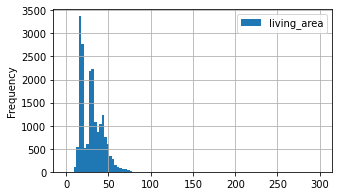

In [30]:
data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,300))

Изучим площадь кухни

<AxesSubplot:ylabel='Frequency'>

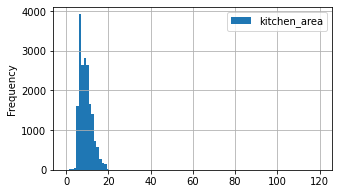

In [31]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,120))

In [32]:
data['kitchen_area'].describe()

count    18623.000000
mean         9.191070
std          2.902425
min          1.300000
25%          7.000000
50%          8.900000
75%         11.000000
max         19.500000
Name: kitchen_area, dtype: float64

Распределение данных в площадях нормальное, от аномальных значений в площади кухни и общей площади мы избавились.

Изучим цену.

<AxesSubplot:ylabel='Frequency'>

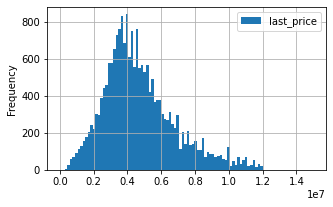

In [33]:
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))

In [34]:
data['last_price'].describe()

count    2.064500e+04
mean     4.707532e+06
std      2.118840e+06
min      4.300000e+05
25%      3.290000e+06
50%      4.300000e+06
75%      5.800000e+06
max      1.190000e+07
Name: last_price, dtype: float64

Распределение нормальное, с данными все хорошо.
Цены на недвижимость имеют среднее значение в 6,5 млн руб., медиана 4,6 млн руб.

Изучим число комнат.

<AxesSubplot:ylabel='Frequency'>

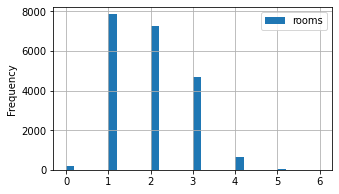

In [35]:
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3))

In [85]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

С данными все впорядке.
Количество комнат колеблется от 0(возможно это студии) до 19. Больше всего однокомнатных квартир.

Изучим высоту потолков

<AxesSubplot:ylabel='Frequency'>

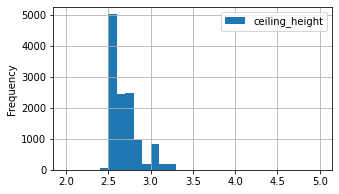

In [36]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))

In [37]:
data['ceiling_height'].describe()

count    12322.000000
mean         2.656908
std          0.168902
min          2.200000
25%          2.500000
50%          2.600000
75%          2.750000
max          3.220000
Name: ceiling_height, dtype: float64

С данными все нормально.

Изучим этажи

<AxesSubplot:ylabel='Frequency'>

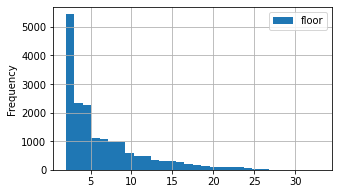

In [38]:
data.plot(y = 'floor', kind = 'hist', bins = 30, range = (2,33), grid=True, figsize = (5,3))

In [39]:
data['floor'].describe()

count    20645.000000
mean         5.932042
std          4.911312
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

С данными все хорошо. Больше всего квартир с невысокими этажами 1-5.

Изучим типы этажей: "первый", "последний" и "другой"

<AxesSubplot:>

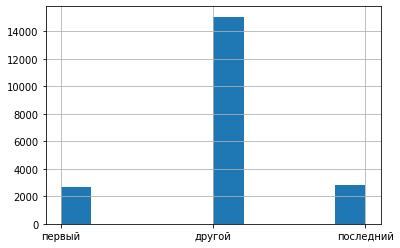

In [40]:
data['type_floor'].hist()

Больше всего квартир с не первым и не последними этажами.

Изучим общее количество этажей в доме

<AxesSubplot:ylabel='Frequency'>

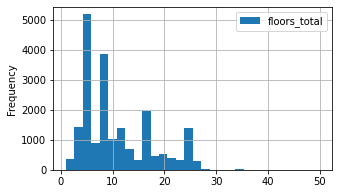

In [41]:
data.plot(y = 'floors_total', kind = 'hist', bins = 30, range = (1,50), grid=True, figsize = (5,3))

In [42]:
data['floors_total'].describe()

count    20572.000000
mean        10.861559
std          6.626503
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Больше всего помещений 5-9 этажами.

Изучим расстояние до центра города в метрах

<AxesSubplot:ylabel='Frequency'>

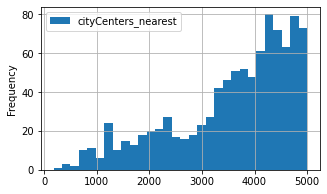

In [43]:
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 30, range = (180,5000), grid=True, figsize = (5,3))

In [44]:
data['cityCenters_nearest'].describe()

count    15306.000000
mean     15256.675617
std       8406.237869
min        329.000000
25%      10927.500000
50%      13816.000000
75%      16802.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Изучим расстояние до ближайшего аэропорта

<AxesSubplot:ylabel='Frequency'>

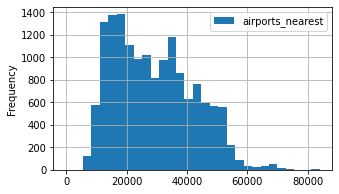

In [45]:
data.plot(y = 'airports_nearest', kind = 'hist', bins = 30, range = (0,84000), grid=True, figsize = (5,3))

In [46]:
data['airports_nearest'].describe()

count    15294.000000
mean     29008.471492
std      13117.645838
min          0.000000
25%      17837.250000
50%      27432.000000
75%      38127.500000
max      84869.000000
Name: airports_nearest, dtype: float64

Изучим расстояние до ближайшего парка

<AxesSubplot:ylabel='Frequency'>

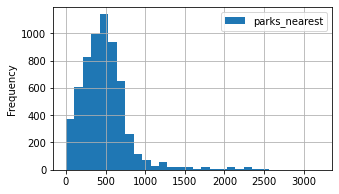

In [47]:
data.plot(y = 'parks_nearest', kind = 'hist', bins = 30, range = (1,3200), grid=True, figsize = (5,3))

In [48]:
data['parks_nearest'].describe()

count    6218.000000
mean      492.184304
std       332.708687
min         1.000000
25%       293.000000
50%       458.000000
75%       617.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Распределения в данных с растояниями нормальное.

Изучим день и месяц публикации объявления

<AxesSubplot:ylabel='Frequency'>

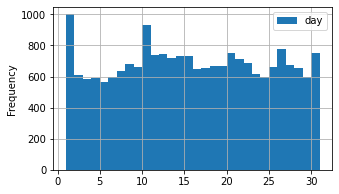

In [49]:
data.plot(y = 'day', kind = 'hist', bins = 30, range = (1,31), grid=True, figsize = (5,3))

In [50]:
data['day'].describe()

count    20645.000000
mean        15.446161
std          8.655849
min          1.000000
25%          8.000000
50%         15.000000
75%         23.000000
max         31.000000
Name: day, dtype: float64

Объявления публикуют примерно одинаково в любой день. Чаще всего публикации происходят в 1 и 10 числах.

<AxesSubplot:ylabel='Frequency'>

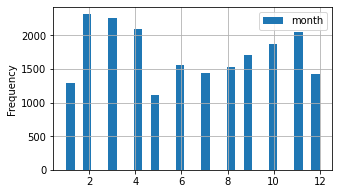

In [51]:
data.plot(y = 'month', kind = 'hist', bins = 30, range = (1,12), grid=True, figsize = (5,3))

In [52]:
data['month'].describe()

count    20645.000000
mean         6.391281
std          3.489481
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

В 1 и 5 месяцах публикаций меньше всего, возможно это связанно с праздниками. Также видно что 2,3,4 и 11 месяца объявляения публиковались чаще.

Вданных были аномальные значения, вроде высоты потолков в 1 или 100 метров и нереалистичных площадей помещений. Мы нашли аномалии диаграмой размаха и удалили их из наших данных. О неадекватных значениях мы спросим у сотрудников, предоставивших нам выборку данных, для общего изучения данных, мы не станем убирать эти выбивающиеся значения.

Изучим время продажи квартиры. 
Дата снятия объявления не гарантирует продажу квартиры, объявление могли снять т.к. передумали продавать или выложили на другой площадке.

<AxesSubplot:ylabel='Frequency'>

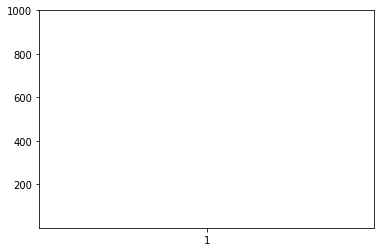

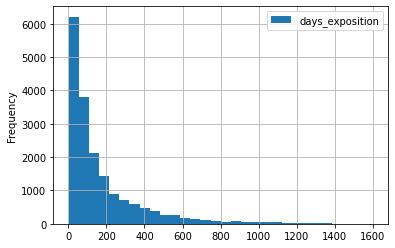

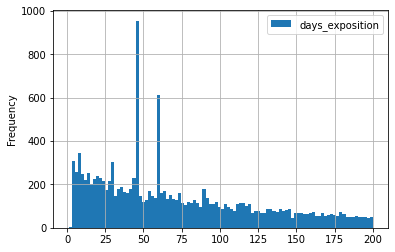

In [53]:
plt.boxplot(data['days_exposition'])
plt.ylim(1,1000)

data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

In [54]:
data[data['days_exposition']!=0]['days_exposition'].describe()

count    18178.000000
mean       170.972879
std        209.590261
min          1.000000
25%         43.000000
50%         90.000000
75%        216.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [55]:
data[data['days_exposition']!=0]['days_exposition'].value_counts()

45.0      868
60.0      507
7.0       218
30.0      190
4.0       160
         ... 
1091.0      1
1060.0      1
1059.0      1
1064.0      1
1131.0      1
Name: days_exposition, Length: 1074, dtype: int64

Среднее значение - 180 дней, а медиана - 95 дней. Сделав гистограмму со значениями от 0 до 200 с кол-вом корзин 100, обнаружили выбивающиеся значения и методом value_counts убедились в этом - у нас аномалии на 45, 60, 7, 30, 90 днях - это наиболее популярное количество дней до снятия объявления. Аномалии нужно убрать.
Исходя из метода describe, межквартильный размах - от 45 до 232 дней, исходя же из метода boxplot - диаграмма размаха у нас от минимального значения до примерно 500 дней. Значит необоснованно быстрых значений у нас нет, а необоснованно долгие - от 500 дней и выше. Нормальные значения у нас лежат от 1 до 500.

Отфильтруем данные от аномалий и запишем их в новый датафрейм good_data.

In [56]:
good_data = data.query('days_exposition != 45 and days_exposition != 30 and days_exposition != 60 and days_exposition != 90 and days_exposition != 7 and days_exposition != 0')

(1.0, 1000.0)

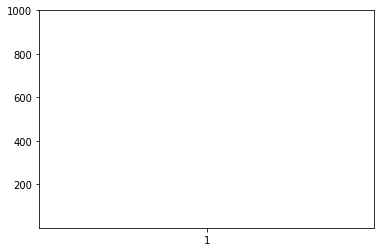

In [57]:
plt.boxplot(good_data['days_exposition'])
plt.ylim(1,1000)

<AxesSubplot:ylabel='Frequency'>

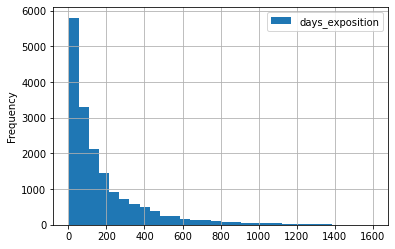

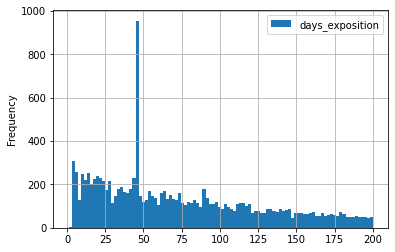

In [58]:
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

In [59]:
good_data['days_exposition'].describe()

count    17263.000000
mean       177.854313
std        212.812593
min          1.000000
25%         45.000000
50%         98.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

Изучим зависимость цены от общей площади квартиры.

0.6856482308460277

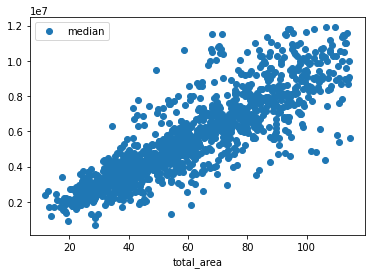

In [60]:
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['last_price'])

Изучим зависимость цены от жилой площади

0.566969164947885

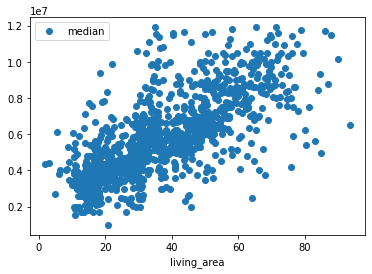

In [61]:
pivot_table_total_area = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['living_area'].corr(data['last_price'])

Изучим зависимость цены от площади кухни

0.47914541993624593

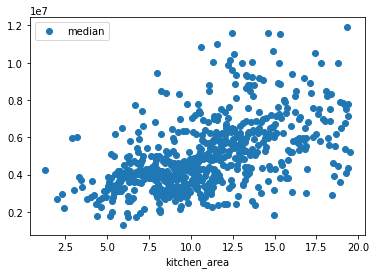

In [62]:
pivot_table_total_area = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['kitchen_area'].corr(data['last_price'])

Зависимость есть. Чем больше площадь тем выше стоимость. 
Зависимость цены сильнее от общей площади помещения и жилой площади. От площади кухни цена зависит меньше.

Изучим зависимость цены от числа комнат.

0.42989037757592197

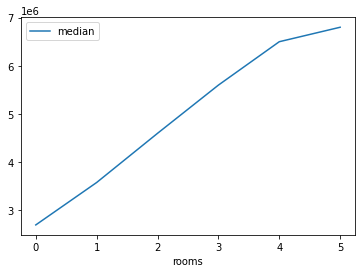

In [63]:
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')

pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)

data['rooms'].corr(data['last_price'])

Зависимость есть, чем больше комнат, тем выше стоимость.

Изучим зависимость цены от этажа (первого или последнего).

<AxesSubplot:xlabel='type_floor'>

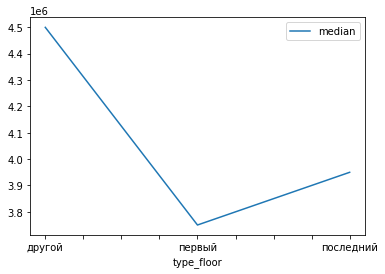

In [64]:
pivot_table_floor_category = data.pivot_table(index = 'type_floor', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')

Согласно графику квартиры на первом этаже самые дешевые. На последнем этаже дороже и на остальных этажах цена выше всего.

Изучим зависимость цены от даты размещения: дня недели.

<AxesSubplot:xlabel='day_of_week'>

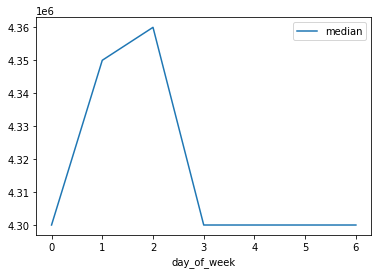

In [65]:
pivot_table_weekday_exposition = data.pivot_table(index = 'day_of_week', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

Видно, что чем ближе ко вторнику выставлены объявления тем в среднем выше стоимость. По выходным стоимость самая низкая.

Изучим зависимость цены от даты размещения: месяца.

<AxesSubplot:xlabel='month'>

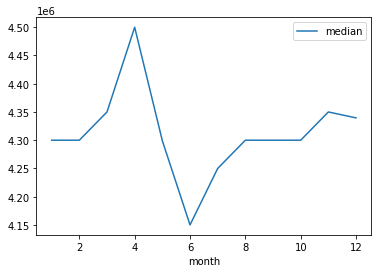

In [66]:
pivot_table_month_exposition = data.pivot_table(index = 'month', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')

Самая высокая стоимость метра в апреле и августе. Самая низкая стоимость в мае и июне.

Изучим зависимость цены от даты размещения: года.

<AxesSubplot:xlabel='year'>

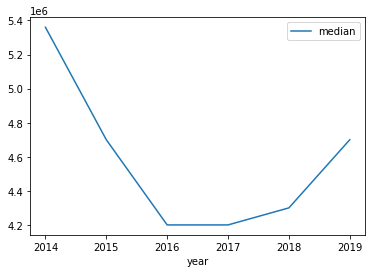

In [67]:
pivot_table_year_exposition = data.pivot_table(index = 'year', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

С 2014 до 2016 года цена падала, но далее начала увеличиваться.

Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим населённые пункты с самой высокой и низкой стоимостью жилья.

In [68]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'm_price', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table

,count,mean
locality_name,,
санкт-петербург,12973,105243.945157
мурино,579,86189.944563
кудрово,447,95506.572228
шушары,432,78682.212013
всеволожск,384,66970.889964
колпино,329,75250.969293
парголово,322,90185.294107
пушкин,321,100016.830102
гатчина,297,68573.726290


In [69]:
#самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]

,count,mean
locality_name,,
санкт-петербург,12973,105243.945157


In [70]:
#самая низкая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
выборг,215,57930.011935


Самая высокая стоимость жилья из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге, тогда как самая низкая стоимость в Выборге.

Выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра. Проанализируем, как стоимость объектов зависит от расстояния до центра города.

<AxesSubplot:xlabel='cityCenters_nearest_km'>

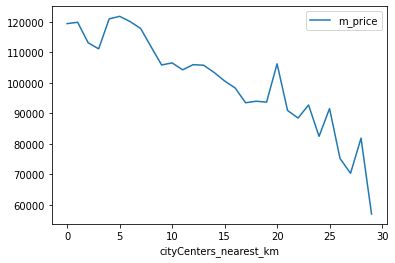

In [71]:
data.query('locality_name == "санкт-петербург" and cityCenters_nearest_km !=999999').pivot_table(index='cityCenters_nearest_km', values='m_price', aggfunc='mean').plot()

In [72]:
data.query('locality_name == "санкт-петербург" and cityCenters_nearest_km !=999999').pivot_table(index='cityCenters_nearest_km', values='m_price', aggfunc='mean')

,m_price
cityCenters_nearest_km,
0,119391.899800
1,119835.325957
2,113116.839460
3,111118.620727
4,120940.920831
5,121782.365124
6,120056.671748
7,117802.264836
8,111764.911737


Чем дальше от цента города, тем цена ниже. Однако на 27км стоимость резко возрастает. Возможно там какой то элитный район.
Судя по графику центром города считается зона примерно в 5км.

### Общий вывод

Мы обработали полученный архив данных - обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для удобной работы. Обработали дубликаты явные и неявные.

Посчитали и добавили в таблицу цену квадратного метра жилья, вывели из даты дни недели, месяцы и года и дни размещения объявлений, добавили категории по этажам квартир, расстояние до центра в километрах. 

Изучили следующие параметры на наличие выбивающихся значений - площадь(общая, жилая, кухни), цена, число комнат, высота потолков, этаж, тип этажа и общее количество этажей в доме, расстояние до центра, аэропорта и парка, день и месяц публикации объявления. Были определены аномалии в данных параметрах.

Мы выявили при помощи диаграммы размаха, что нормальные значения продажи квартир варьируются от 1 до 500 дней. Самые большие аномалии на 45 и 60 днях, возможно это дни, когда объявления завершаются по сроку действия и пользователи их снова не публикуют. Нужно ознакомиться с правилами сервиса.
Мы выявили, что на стоимость квадратного метра квартиры больше всего влияют количество комнат, этаж квартиры, близость к центру. Незначительно на стоимость квадратного метра влияют день, месяц, год размещения и площадь. 